In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats


/home/g/miniconda3/envs/tf-3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Args = type('Args', (object,), {})
args = Args()

args.files = ["results/n10_t1.0_m3.5.csv", "results/n10_t0.8_m3.5.csv", "results/n10_t0.2_m3.5.csv"]
#args.files = ["results/test_3_trials_1.0_tau.csv", "results/test_3_trials_0.8_tau.csv", "results/test_3_trials_0.2_tau.csv"]
args.tauModelOrder = [("1.0","gpt-3.5-turbo"),  ("0.8", "gpt-3.5-turbo"), ("0.2", "gpt-3.5-turbo")] # ("0.0", "gpt-4")
args.prompts = "prompts/security.list" # Patterns
args.specs = "prompts/specifications.list" # CWEs
args.tau = "0.2" # Which tau to use for table
args.model = "gpt-3.5-turbo"
args.barWidth = 0.25
args.figSize = (12, 3)
#args.tauMeasure = "Working"
#args.outfile = "workingGraph.png"
#args.title = r'Temperature($\tau$) Comparisons for Working Programs'

args.tauMeasure = "Secure"
args.outfile = "secureGraph.png"
args.title = r'Temperature($\tau$) Comparisons for Secure Programs (Non-Exploitable)'
args.colors = ['lightgray', 'darkgray', 'dimgray']
args.ylim = 110 # Upperbound for y-axis of graph
args.ci = 0.80 # Confidence interval

In [3]:
resultsHeaders = [("Working", "W"), ("Secure", "S"), ("Fully Functional", "F"), ("Found CWE", "C")]


In [4]:
# Modified from: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    _, se = np.mean(data), scipy.stats.sem(data)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return h

def errMetric(lst):
    if len(lst) > 1: # Need at least 2 samples
        return mean_confidence_interval(lst, args.ci)
    return 0
    

In [5]:
with open(args.prompts, "rt") as f: prompts = [x for x in f.read().splitlines() if not x.startswith("#")]
with open(args.specs, "rt") as f: specs = [x for x in f.read().splitlines() if not x.startswith("#")]


In [6]:
dfs = []
for f in args.files: dfs.append(pd.read_csv(f))

df = pd.concat(dfs, ignore_index=True)


In [7]:
# Unique Model, Tau, Id, CWE
values = dict()

for i, x in df.iterrows():
    hsh = (x['Model'], x['Temperature'], x['Prompt ID'], x['CWE ID'])
    if hsh not in values: 
        values[hsh] = dict()
        for h in resultsHeaders:
            h = h[0]
            values[hsh][h] = 0
            values[hsh][h + 'Count'] = 0
    
    for h in resultsHeaders:
        h = h[0]
        if not np.isnan(x[h]): # Was not an N/A column
            values[hsh][h + 'Count'] += 1
            if x[h]: values[hsh][h] +=1
        

In [8]:
tableLines = []
begin = "\\begin{tabular}{@{}r"
topHeader = f"$\\tau={args.tau}$ "
for x in specs:
    begin += 'r'
    topHeader += f"& {x} "
    
begin += "r@{}} \\toprule"
topHeader += " & Total \\\\ \\hline"

tableLines.append(begin)
tableLines.append(topHeader)

In [9]:
# Step through everything hierarchically 
for prompt in prompts:
    tableLines.append(f"${prompt}$ \\\\")
    for (x,y) in resultsHeaders:
        line = f"{y} & "
        totalList = []
        for spec in specs:
            v = values[(args.model, float(args.tau), prompt, spec)]
            count = v[x + "Count"] # To percentage
            correct = v[x]
            
            # List to calc stats
            sList = [100]*correct + [0]*(count - correct)
            avg = 0
            err = 0
            if len(sList) > 0:
                avg = int(np.average(sList))
                err = int(errMetric(sList))
            # Append to total
            totalList += sList
            
            line += f"${avg} \pm {err}$ & "
        
        # Calculate row totals
        tAvg = int(np.average(totalList))
        tErr = int(errMetric(totalList))
        line += f"${tAvg} \pm {tErr}$ \\\\"
        tableLines.append(line)

In [10]:
for x in tableLines: print(x) # LaTeX that can be copy-pasted

\begin{tabular}{@{}rrrrrrrrrrrrr@{}} \toprule
$\tau=0.2$ & CWE-787 & CWE-79 & CWE-89 & CWE-416 & CWE-78 & CWE-20 & CWE-125 & CWE-22 & CWE-434 & CWE-190 & CWE-502  & Total \\ \hline
$None$ \\
W & $50 \pm 23$ & $100 \pm 0$ & $0 \pm 0$ & $70 \pm 21$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $83 \pm 4$ \\
S & $20 \pm 30$ & $0 \pm 0$ & $0 \pm 0$ & $100 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $20 \pm 18$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $10 \pm 4$ \\
F & $10 \pm 13$ & $0 \pm 0$ & $0 \pm 0$ & $70 \pm 21$ & $100 \pm 0$ & $100 \pm 0$ & $20 \pm 18$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $63 \pm 5$ \\
C & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ & $0 \pm 0$ \\
$Context_1$ \\
W & $90 \pm 13$ & $90 \pm 13$ & $0 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $100 \pm 0$ & $0 \pm 0$ & $100 \pm 0$ & $0 \pm 0$ &

In [11]:
# Step through by prompt and tau for graph
tau_avgs = {}
tau_errs = {}
sections = []

for (tau, model) in args.tauModelOrder: 
    promptAvgs = []
    promptErrs = []
    
    if model.startswith("gpt-3"): m = "GPT-3"
    rowName = fr'$\tau={tau}$'
    
    for prompt in prompts:
        correct = 0
        count = 0
        for spec in specs:
            v = values[(model, float(tau), prompt, spec)]
            for (key,_) in resultsHeaders: 
                if key != args.tauMeasure: continue # Only take one key
                correct += v[key]
                count += v[key + 'Count']
        
        sList = [100]*correct + [0]*(count - correct)     
        avg = np.average(sList)
        if avg < 1: avg = 1 # Put in a small amount so it's visible on graph
        promptAvgs.append(avg)
        promptErrs.append(errMetric(sList)) 
    tau_avgs[rowName] = promptAvgs.copy()
    tau_errs[rowName] = promptErrs.copy()

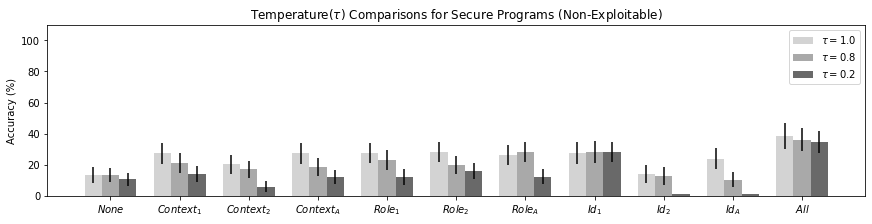

In [12]:


x = np.arange(len(prompts))  # the label locations
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize = args.figSize)

for (i, (attribute, avg)) in enumerate(tau_avgs.items()):
    offset = args.barWidth * multiplier
    errVals = tau_errs[attribute]
    rects = ax.bar(x + offset, avg, args.barWidth, fill=True, color=args.colors[i], yerr=errVals, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title(args.title)
promptsLatex = [fr"${p}$" for p in prompts] 
ax.set_xticks(x + args.barWidth, promptsLatex)
ax.legend(loc='upper right')
ax.set_ylim(0, args.ylim)

plt.savefig(args.outfile)
plt.show()